In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'iqothnccd-lung-cancer-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1748489%2F2882784%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240311%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240311T192222Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D72025accdc61aca3db130c9a19eba3cd9fc0cc41c09365bebfb012732c535d6b6dd408378d1be327b5a64d4f5d4ee8a6108f4450c4a938a80f93d2fd770dec8731fdc1353544effe53d5084ca2810de8ef9ce92d489da75fb3930dfd29f5210afa228ba6f4c9f266dee8acc6ae62bdcd261540e8936ca9dc26f88ce0cba7882f0990d00532872ce0cb17909cb123dac5962026f4b67a4a270cf0e426de07d5fe1bd54eae5e4a4080109d52c6692b8c0dc49311045ab29c79377c8771eff82d46b030d6fd9ecd7f70b13d1e0545f8f7c3efcc8f5215ba999d870cc3a2ec7a7bee727b14ab8107b3595f5d323304a85fc9011b6c017356cd945916271b16f36f3c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


OSError: [Errno 30] Read-only file system: '/kaggle'

# Import Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D,Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
import os
import cv2

# Construct Filepath image to dataframe with image classes

In [ ]:
bengin_path = r"/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases"
malignant_path = r"/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases"
normal_path = r"/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases"

img_classes = ["Bengin cases", "Malignant cases", "Normal cases"]
path_list = [bengin_path, malignant_path, normal_path]

img_path = []
class_labels = []
for i, dir_list in enumerate(path_list):
    name_img = os.listdir(dir_list)
    for name_file in name_img:
        img = os.path.join(dir_list,name_file)
        img_path.append(img)
        class_labels.append(img_classes[i])

df = pd.DataFrame({"img_path" : img_path,
                  "label" : class_labels})

df.head()

,img_path,label
0,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Bengin cases
1,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Bengin cases
2,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Bengin cases
3,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Bengin cases
4,/kaggle/input/iqothnccd-lung-cancer-dataset/Th...,Bengin cases


# Visualization Image

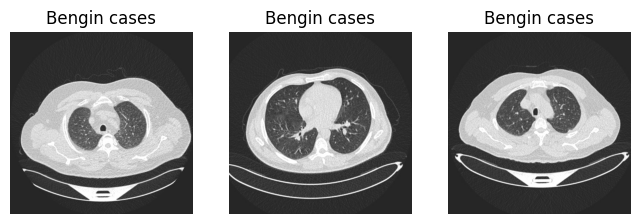

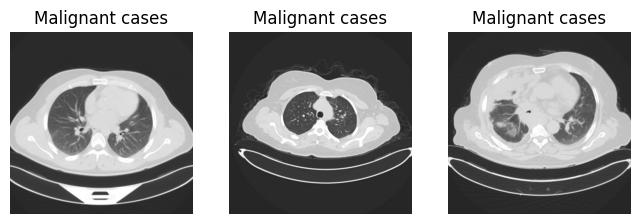

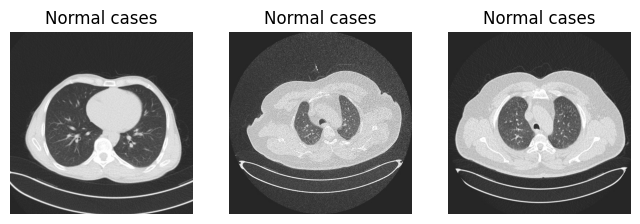

In [ ]:
for category, group in df.groupby("label"):
    fig, ax = plt.subplots(1,3, figsize = (8,8))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(3).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

# Exploratory Data Analysis

In [ ]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [ ]:
countData = df["label"].value_counts().reset_index()
fig = px.histogram(data_frame = countData, x = "index", y = "label")
fig.show(renderer="colab")

## Extract Image Properties (Size, Resolution, Color Distribution)

In [ ]:
sizes = []
resolutions = []
color_distributions = []

for img_path in df["img_path"]:
    #load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Get image size
    size = os.path.getsize(img_path)
    sizes.append(size)
    #Extract the resolution of images
    resolution = img.shape[:2]
    resolutions.append(resolution)
    #Extract color distribution
    mean_color_distributions = np.bincount(img.flatten(), minlength = 256)
    color_distributions.append(mean_color_distributions)
sizes = np.array(sizes)
resolutions = np.array(resolutions)
color_distributions = np.array(color_distributions)

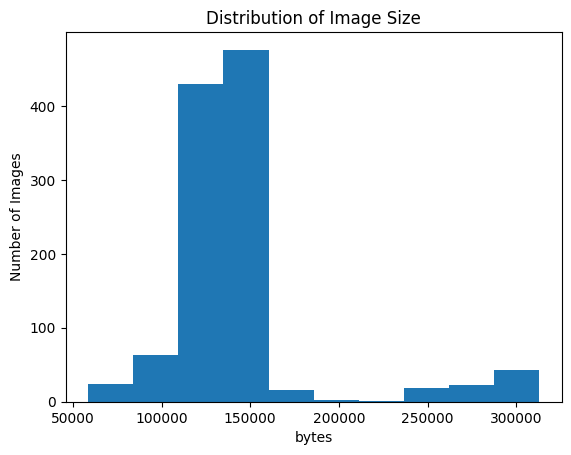

In [ ]:
plt.hist(sizes)
plt.title("Distribution of Image Size")
plt.xlabel("bytes")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
#Sizes in MB
sizes_MB = []
for img_path in df["img_path"]:
    #load image
    img = cv2.imread(img_path)
    #Get image size
    size = os.path.getsize(img_path)
    sizes_MB.append(size/1_000_000)

fig = px.histogram(x=sizes_MB, nbins = 50, title = "Distribution of Image Sizes")
fig.update_layout(xaxis_title = "File Size (MB)",
                 yaxis_title = "Number of Images",
                 showlegend = False,
                 bargap = 0.1,
                 bargroupgap = 0.1)
fig.update_traces(marker = dict(color = "green"))
fig.show(renderer="colab")


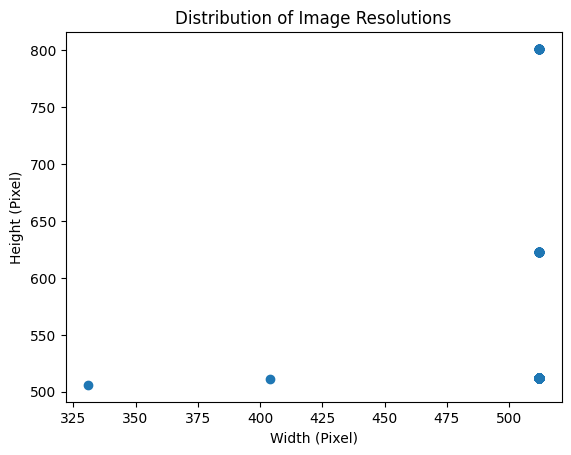

In [ ]:
plt.scatter(resolutions[:,0], resolutions[:,1])
plt.title("Distribution of Image Resolutions")
plt.ylabel("Height (Pixel)")
plt.xlabel("Width (Pixel)")
plt.show()

In [ ]:
fig = px.scatter(x = resolutions[:,0], y = resolutions[:,1], title = "Distribution of Image Resolution")
fig.update_layout(
    xaxis_title = "Width (Pixel)",
    yaxis_title = "Height (Pixel)",
    showlegend = False,
    hovermode = "closest"
)
fig.update_traces(marker = dict(color="red"))
fig.show(renderer="colab")


In [ ]:
import plotly.graph_objects as go
mean_color_distributions = np.mean(color_distributions, axis = 0)
fig = go.Figure(
    go.Bar(x = np.arange(256), y = mean_color_distributions, name = "Mean Color Distributions"
))
fig.update_layout(
    title = "Mean Color Distribution",
    xaxis_title = "Color Values",
    yaxis_title = "Number of Pixel"
)
fig.show(renderer="colab")


# Train Test Split

In [ ]:
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

df_train, df_test_val = train_test_split(df, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio+val_ratio), random_state = 42)

print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")

Train shape = (767, 2)
Test shape = (165, 2)
Validation shape = (165, 2)


# Create Denoise Function using Median Blur

In [ ]:
def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 1)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

# Image Data Generator

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32

TRAIN_DATAGEN = ImageDataGenerator(rescale = 1./255.,
                                   preprocessing_function = preprocessing_denoise,
                                  rotation_range = 30,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.2,
                                  shear_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

TEST_DATAGEN = ImageDataGenerator(rescale = 1./255.)

train_generator = TRAIN_DATAGEN.flow_from_dataframe(
    df_train,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

val_generator = TEST_DATAGEN.flow_from_dataframe(
    df_val,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

test_generator = TEST_DATAGEN.flow_from_dataframe(
    df_test,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

Found 767 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.


In [ ]:
classes = list(train_generator.class_indices.keys())
classes

['Bengin cases', 'Malignant cases', 'Normal cases']

In [ ]:
#Weight Class
class_weights = class_weight.compute_class_weight(
           class_weight = 'balanced',
            classes = np.unique(train_generator.classes),
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

for idx, weight, in train_class_weights.items():
    class_name = classes[idx]
    print(f"{class_name} : {weight}")

Bengin cases : 3.1958333333333333
Malignant cases : 0.6606373815676141
Normal cases : 0.8522222222222222


# Create Custom CNN Model

In [ ]:
model1 = Sequential([
    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), input_shape = (224, 224, 3), activation = "relu", padding = "same"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Flatten(),
    Dense(4096, activation = "relu"),
    Dropout(0.5),
    Dense(256),
    Dropout(0.25),
    Dense(3, activation = "softmax")
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                        

In [ ]:
model1.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(learning_rate = 0.0005),
    metrics = ["accuracy"],
)

epochs = 50
history = model1.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 32,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min')
                              ],
                   epochs = epochs)

In [ ]:
def history_plot(epochs, history):
    fig1 = make_subplots()
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["accuracy"], name = "Training Accuracy"))
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_accuracy"], name = "Validation Accuracy"))
    fig1.update_layout(title = "Training and Validation Accuracy", xaxis_title = "Epoch", yaxis_title = "Accuracy")
    fig1.show()

    fig2 = make_subplots()
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["loss"], name = "Training Loss"))
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_loss"], name = "Validation Loss"))
    fig2.update_layout(title = "Training and Validation Loss", xaxis_title = "Epoch", yaxis_title = "Loss")
    fig2.show()

history_plot(epochs, history)

In [ ]:
def evaluate_model(model, test_generator):
    #Calculate test loss and accuracy
    results = model.evaluate(test_generator, verbose = 0)
    print(f"Test Loss = {results[0]}")
    print(f"Test Accuracy = {results[1]}")

In [ ]:
evaluate_model(model1, test_generator)

In [ ]:
model1.save("CNN(Custom).keras")

# Using Pretrained Model ResNet50

In [ ]:
base_model = ResNet50(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = "imagenet")


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model2 = Sequential()
model2.add(Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(1024, activation = "relu"))
model2.add(Dropout(0.4))
model2.add(Dense(3, activation = "softmax"))

print(model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 126352259 (482.00 MB)
Trainable params: 102764547 (392.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
None

In [ ]:
epochs = 50
model2.compile(optimizer = Adam(0.0005),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])
history = model2.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                              ],
                   epochs = epochs)

Epoch 1/50
24/24 [==============================] - 35s 1s/step - loss: 8.1025 - accuracy: 0.3520 - val_loss: 1.2498 - val_accuracy: 0.2788 - lr: 5.0000e-04
Epoch 2/50
24/24 [==============================] - 19s 788ms/step - loss: 1.5985 - accuracy: 0.4342 - val_loss: 1.2852 - val_accuracy: 0.4182 - lr: 5.0000e-04
Epoch 3/50
24/24 [==============================] - 15s 607ms/step - loss: 1.1385 - accuracy: 0.4550 - val_loss: 1.2313 - val_accuracy: 0.1758 - lr: 5.0000e-04
Epoch 4/50
24/24 [==============================] - ETA: 0s - loss: 1.0414 - accuracy: 0.4289

KeyboardInterrupt: 

In [6]:
evaluate_model(model2, test_generator)

NameError: name 'evaluate_model' is not defined

# Fine Tuning Pretrained Model : ResNet50

In [ ]:
base_model.trainable = True

for l in base_model.layers[:10]:
    print(l.name, l.trainable)

model2.compile(optimizer = Adam(0.00001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

print(model2.summary())

In [ ]:
epochs = 50
history = model2.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                              ],
                   epochs = epochs)

In [ ]:
history_plot(epochs, history)

In [ ]:
evaluate_model(model2, test_generator)

In [ ]:
model2.save("InceptionV3.keras")

# Pretrained Model VGG-16

In [ ]:
base_model_vgg16 = VGG16(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = "imagenet")

In [ ]:
for layer in base_model_vgg16.layers:
    layer.trainable = False

In [ ]:
model3 = Sequential()
model3.add(Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
model3.add(base_model)
model3.add(Flatten())
model3.add(Dense(1024, activation = "relu"))
model3.add(Dropout(0.4))
model3.add(Dense(3, activation = "softmax"))

print(model3.summary())

In [ ]:
model3.compile(optimizer = Adam(0.0005),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

epochs = 50
history = model3.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min')
                              ],
                   epochs = epochs)

In [ ]:
history_plot(epochs, history)

In [ ]:
evaluate_model(model3,test_generator)

# Fine Tuning Model VGG16

In [4]:
base_model_vgg16.trainable = True
set_trainable = False
for layer in base_model_vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model3.compile(optimizer = Adam(0.00001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

NameError: name 'base_model_vgg16' is not defined

In [ ]:
epochs = 50
history = model3.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min')
                              ],
                   epochs = epochs)

In [ ]:
history_plot(epochs,history)

In [ ]:
evaluate_model(model3, test_generator)

In [ ]:
model3.save("VGG16.keras")

In [ ]:
from IPython.display import FileLink
FileLink(r'VGG16.keras')

# Conclusion

In [3]:
models = [model1, model2, model3]
loss = []
accuracy = []
for model in models:
    results = model.evaluate(test_generator, verbose = 0)
    loss.append(results[0])
    accuracy.append(results[1])

NameError: name 'model1' is not defined

In [2]:
name_models = ["CNN (Custom)", "InceptionV3", "VGG16"]
df_loss_acc = pd.DataFrame(data = {"Name_Models" : name_models,
                                  "Loss" : loss,
                                  "Accuracy" : accuracy})

fig = px.bar(data_frame = df_loss_acc, x = "Name_Models", y = ["Accuracy", "Loss"],
            barmode = "group",
            text_auto = ".3f")
fig.show()

NameError: name 'pd' is not defined

The best model is VGG16 with higher accuracy and lowest loss